In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";  # The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  # Do other imports now...

import tensorflow as tf
    
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)

from datetime import datetime
from keras.models import Model
from keras.layers import Input, Dense, Dot, Add, Flatten, Concatenate, Embedding, LSTM, GRU, Input, Dense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

import pandas as pd
import numpy as np
from tqdm import tqdm_notebook, tqdm
tqdm.pandas()
import gc
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, recall_score, precision_score, mean_squared_error
import json

In [3]:
import random
seed_value = 42
def init_seeds():
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    
init_seeds()

# Loading Family-Intervals for the dataset

In [195]:
def read_dict(name):
    with open(name, 'r') as f:
        return json.load(f)
    
family_intervals = read_dict('../Family_Intervals/intervals.json')
# family_intervals = read_dict('../data_hero_ds/family_intervals.json')

index_to_name = read_dict('../Family_Intervals/Family_Indexes.json')
# index_to_name = read_dict('../data_hero_ds/Family_Indexes.json')

index_to_interval = []
for key in index_to_name.keys():
    index_to_interval += [family_intervals[index_to_name[key]]]


In [5]:
def get_number_of_active_families(vec):
    count = 0
    for interval in index_to_interval:
        for i in interval:
            if vec[i] == 1:
                count += 1
                break
    return count
                

# Picking Top-K individuals for clustering

In [6]:
def get_mask(family,indlength=661):
    family_intervals = index_to_interval
    mask = np.array([0] * indlength)

    for family_mask_index in range(len(family)):
        family_interval = family_intervals[family_mask_index]
        for feature_index in family_interval:
            mask[feature_index] = family[family_mask_index]
    
    return mask

# returns all unique inds that were present in an expr
def get_all_inds(pop_dict, with_family=False):
    all_inds = set()
    gens = list(pop_dict.keys())
    for gen_number in gens:
        pop_gen = pop_dict[gen_number]
        if with_family:
            pop_gen = [tuple([tuple(i[0]), tuple(i[1])]) for i in pop_gen]
        else:
            pop_gen = [tuple(i) for i in pop_gen]
        all_inds.update(pop_gen)
    
    return all_inds

def get_top_n_from_gens(pop_dict, fitness_dict, n, top_biggest = False, gen=None, with_family=False):
    inds = None
    
    if gen is None:
        inds = get_all_inds(pop_dict, with_family)
    else:
        inds = list(map(lambda i:tuple(i), pop_dict[gen]))
        
    inds = list(inds)
    inds.sort(key =  lambda ind: fitness_dict[str(ind)] if str(ind) in fitness_dict else 0)
    
    if top_biggest:
        inds.reverse()
    
    desired_inds = inds[0:n]
    inds_metric = list(map(lambda ind : fitness_dict[str(ind)] if str(ind) in fitness_dict else 0, desired_inds))
    
    
    if with_family:
        desired_inds = [np.multiply(np.array(i[0]), np.array(get_mask(i[1]))) for i in desired_inds]
        
    return desired_inds, inds_metric

def get_top_n_ind_from_expr(folder, n, top_biggest = False, gen=None, with_family=False):
    fitness_dict = read_dict(folder + "fitness_dict.json")
    pop_dict = read_dict (folder + "gens_dict.json")
    
    key_func = lambda ind: fitness_dict[str(ind)]
    return get_top_n_from_gens(pop_dict, fitness_dict, n, top_biggest = top_biggest, gen=gen, with_family=with_family)
    
def display_ind_stats(ind):
    print("SUM(IND) = {} ".format(sum(ind)))
    print("METRIC = {} ".format(fitness_dict[str(ind)]))

In [27]:
top_inds_full_train,top_metric2 = get_top_n_ind_from_expr(
   folder = '../Results/GA_RES_17_4_TOURNAMNET_ONLY_PRED/' ,n = 5000,top_biggest = True, with_family=False)

# Picking Optimal Eps For DBScan

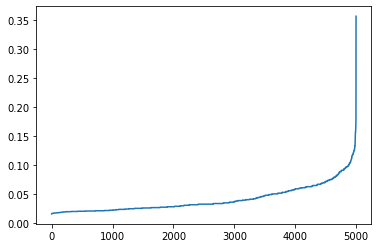

In [32]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

X = np.array(top_inds_full_train)
neigh = NearestNeighbors(n_neighbors=2, metric='jaccard')
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)


# Interpolation of the distance function 

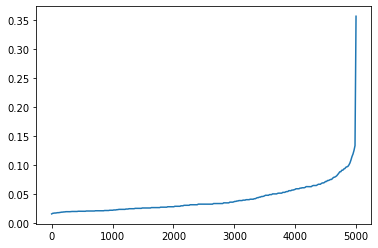

In [35]:
from scipy.interpolate import make_interp_spline, BSpline

T = np.array(list(range(len(distances))))
xnew = np.linspace(T.min(), T.max(), 300) 

spl = make_interp_spline(T, distances, k=11)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()


# Calculating point of maximum curvature  

0.09090961172695142


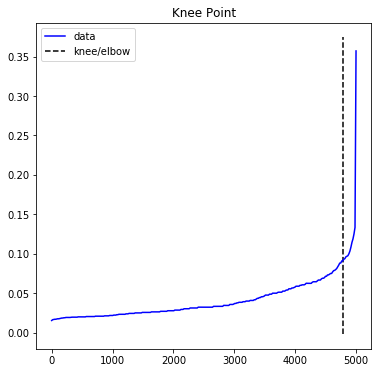

In [36]:
from kneed import DataGenerator, KneeLocator
kneedle = KneeLocator(xnew, power_smooth, S=1.0, curve='convex', direction='increasing')
eps = kneedle.knee_y
print(eps)
kneedle.plot_knee()

# Picking Individuals From Clusters

In [7]:
from sklearn.metrics import jaccard_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN


def get_best_from_cluster(X, clusters, m):
    """
    Taken the best individual from every cluster. 
    Because they sorted by AUC, the best is the first one we iteratively find.
    """
    print("taking best")
    inds_ens = []
    taken_clusters = []
    for index, ind in enumerate(X):
        cluster = m.labels_[index]
        if cluster in taken_clusters:
            continue

        taken_clusters += [cluster]
        inds_ens += [ind]
    
    return inds_ens

def get_shortest_from_every_cluster(X, clusters, m):
    print("taking shortest")
    inds_ens = []
    taken_clusters = set()
    cluster_to_ind_mapping = {}
    
    sanity = {}
    
    for index, ind in enumerate(X):
        cluster = m.labels_[index]
        
        if cluster not in sanity:
            sanity[cluster] = []
        
        sanity[cluster].append(sum(ind))
        
        # taking the ind if we don't have anyone from the cluster or we find someone shorter than him.
        if cluster not in taken_clusters or sum(cluster_to_ind_mapping[cluster]) > sum(ind):
            taken_clusters.add(cluster)
            cluster_to_ind_mapping[cluster] = ind
            continue
    
    
    for key_cluster in cluster_to_ind_mapping.keys():
        assert sum(cluster_to_ind_mapping[key_cluster]) == min(sanity[key_cluster])
    
    
    inds_ens = list(cluster_to_ind_mapping.values())
    return inds_ens

def get_random_from_every_cluster(X, clusters, m):
    print("taking random")
    inds_ens = []
    
    clusters_to_inds_mapping = {}
    
    for index, ind in enumerate(X):
        cluster = m.labels_[index]
        
        if cluster not in clusters_to_inds_mapping:
            clusters_to_inds_mapping[cluster] = []
        
        clusters_to_inds_mapping[cluster].append(ind)
    
    import random
    
    for lst in clusters_to_inds_mapping.values():
        inds_ens.append(random.choice(lst))
        
    return inds_ens
    

        


def get_top_n_inds_by_DBSCAN(inds, eps):
    print(eps)
    X = np.array(inds)
    m = DBSCAN(eps=eps, min_samples=10, metric='jaccard')
    m.fit(X)
    return m

def select_from_clusters(X, m, method='best'):

    clusters = list(set(m.labels_))
    params = {"X":X, "clusters":clusters, "m":m}
    
    if method == 'best':
        return get_best_from_cluster(**params)
    
    elif method == 'shortest':
        return get_shortest_from_every_cluster(**params)
    
    elif method == 'random':
        return get_random_from_every_cluster(**params)
    
    
    

In [8]:
def get_top_n_inds_by_jaccard(best ,inds ,thres = 0.80, n=24):
    X = np.array(inds)
    inds_ens = [best]
    
    for ind in top_inds_full_train[1:]:
        
        if len(inds_ens) == n:
            break
        
        current_avg_score = sum(list(map(lambda x : jaccard_score(x, ind) , inds_ens)))/len(inds_ens)
        if current_avg_score < thres:
            inds_ens.append(ind)
        
    
    return inds_ens
    

In [1]:
mapping = get_top_n_inds_by_DBSCAN(top_inds_full_train, eps=eps)

In [43]:
method = 'best'
inds_ens = select_from_clusters(np.array(top_inds_full_train), mapping, method)

taking best


In [44]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, metric='jaccard', learning_rate=200).fit_transform(np.array(top_inds_full_train))


# Visualizing The Clusters

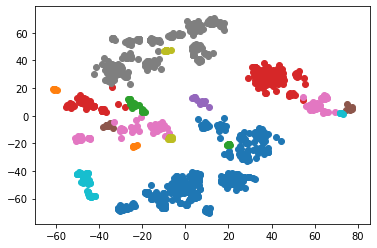

In [45]:
import matplotlib.pyplot as plt
unique_labels = set(mapping.labels_)

def get_all_from_cluster(X, labels, cluster):
    indexes = list(filter(lambda i : labels[i] == cluster , list(range(len(X)))))
    return list(map(lambda i : X[i], indexes))
    


for color in unique_labels:
    if color == -1:
        continue
    to_plot = np.array(get_all_from_cluster(X_embedded, mapping.labels_, color))
    X_plot = to_plot[:,0]
    y_plot = to_plot[:,1]
    
    plt.scatter(X_plot, y_plot, label = color)

# Load Hearo Dataset context

In [111]:
# def get_train_test_val_split(arr):
#     x_train, x_test = train_test_split(arr, test_size=0.3 , shuffle=False)
#     x_val ,x_test = train_test_split(x_test, test_size=0.66 , shuffle = False)
#     return x_train, x_test, x_val

# y_train, y_test, y_val =get_train_test_val_split(np.load('../data_hero_ds/y.npy'))
# item_train, item_test, item_val = get_train_test_val_split(np.load('../data_hero_ds/items.npy'))
# user_train, user_test, user_val = get_train_test_val_split(np.load('../data_hero_ds/users.npy'))
# context_train, context_test, context_val = get_train_test_val_split(np.load('../data_hero_ds/X.npy'))



# assert len(y_train) == len(item_train) and len(y_train) == len(user_train) and len(y_train) == len(context_train)
# assert len(y_test) == len(item_test) and len(y_test) == len(user_test) and len(y_test) == len(context_test)
# assert len(y_val) == len(item_val) and len(y_val) == len(user_val) and len(y_val) == len(context_val)

# Load CARS Dataset context

In [196]:
import numpy as np

from sklearn.model_selection import train_test_split


y_train, y_test, y_val = np.load('../data/y_train.npy'), np.load('../data/y_test.npy'),np.load('../data/y_val.npy')
item_train, item_test, item_val = np.load('../data/item_train.npy'),np.load('../data/item_test.npy'),np.load('../data/item_val.npy')
user_train, user_test, user_val = np.load('../data/user_train.npy'),np.load('../data/user_test.npy'),np.load('../data/user_val.npy')
context_train, context_test, context_val = np.load('../data/context_train.npy'),np.load('../data/context_test.npy'),np.load('../data/context_val.npy')


In [99]:
def reduce_features(ind, arr):
    res = []
    for i in range(len(ind)):
        if ind[i] == 1:
            res += [arr[i]]
    return np.array(res)


def reduce_by_ind(x_arr, ind):
    return np.array(list(map(lambda row : reduce_features(ind, row) , x_arr)))


In [100]:
source_unique = max([max(user_test), max(user_train), max(user_val)]) + 1
print(source_unique)

target_unique = max([max(item_test), max(item_train), max(item_val)]) + 1
print(target_unique)

76
227


# Contextual Modeling Architecture

In [68]:
from keras.layers import Dropout
from keras.layers import BatchNormalization

default_info = {'final_activation':'sigmoid', 'loss':'binary_crossentropy',
                     'dropout' : True , 'batch_norm' : True
                   }

def get_full_arch(context_dim, info=None):
    embedding_dim = 16
    final_activation='sigmoid'
    loss='binary_crossentropy'
    print("FULL ARCH {}, emb_dim = {}, loss = {}, activation = {}".format(context_dim, embedding_dim, loss, final_activation))
    input_target = Input(shape=[1], name="input_item")
    input_source = Input(shape=[1], name="input_user")
    input_context = Input(shape=[context_dim], name="input_context")

    target_emb = Embedding(input_dim=target_unique, output_dim=embedding_dim,
                           input_length=1, name='target_emb')(input_target)
    source_emb = Embedding(input_dim=source_unique, output_dim=embedding_dim,
                           input_length=1, name='source_emb')(input_source)

    target_emb_mlp = Embedding(input_dim=target_unique, output_dim=embedding_dim,
                              input_length=1, name='target_emb_mlp')(input_target)
    source_emb_mlp = Embedding(input_dim=source_unique, output_dim=embedding_dim,input_length=1, name='source_emb_mlp')(input_source)

    # adding bias
    target_bias = Embedding(input_dim=target_unique, output_dim=1,
                            input_length=1, name='target_bias')(input_target)
    source_bias = Embedding(input_dim=source_unique, output_dim=1,
                            input_length=1, name='source_bias')(input_source)

    target_flat = Flatten()(target_emb)
    source_flat = Flatten()(source_emb)

    target_flat_mlp = Flatten()(target_emb_mlp)
    source_flat_mlp = Flatten()(source_emb_mlp)

    concat = Concatenate()([target_flat_mlp, source_flat_mlp, input_context])

    target_flat_bias = Flatten()(target_bias)
    source_flat_bias = Flatten()(source_bias)
    
    print("With Batch Normalization")
    mlp_dense_input = Dense(200, name='mlp_dense_in', activation='relu')(concat)
    b0 = BatchNormalization()(mlp_dense_input)
    mlp_hidden_0 = Dense(100, name='mlp_hidden_0', activation='relu')(b0)

    b1 = BatchNormalization()(mlp_hidden_0)
    mlp_hidden_1 = Dense(50, name='mlp_hidden_1', activation='relu')(b1)
    b2 = BatchNormalization()(mlp_hidden_1)    
    mlp_dense_out = Dense(1, name='mlp_dense_out', activation='sigmoid')(b2)
         

    dot = Dot(axes=1, name='dot')([source_flat, target_flat])

    add = Add()([dot, target_flat_bias, source_flat_bias])

    # creating a 1*2 vector that is a concatenation between the two sides
    concat_left_and_right = Concatenate()([add, mlp_dense_out])
    
    print("With Dropout")
    concat_left_and_right = Dropout(rate = 0.5, seed = 42)(concat_left_and_right)
    
    last_layers_n = 6
    final_mlp_dense_input = Dense(last_layers_n, name='final_dense_in', activation = 'relu')(concat_left_and_right)
    final_mlp_dense_out =  Dense(1, name='final_dense_out', activation=final_activation)(final_mlp_dense_input)


    model = Model(inputs=[input_target, input_source, input_context], outputs=final_mlp_dense_out)

    model.compile(optimizer='adam', loss=loss, metrics=['mae'])

    
    return model

# Training a model from every cluster

In [3]:
import warnings
warnings.filterwarnings('ignore')

preds_val = []
preds_test = []

for ind in tqdm(inds_ens):
    

    
    x_train_GA = [item_train, user_train]
    x_test_GA = [item_test, user_test]
    x_val_GA = [item_val, user_val]
    
    x_train_GA.append(reduce_by_ind(context_train, ind))
    x_test_GA.append(reduce_by_ind(context_test, ind))
    x_val_GA.append(reduce_by_ind(context_val, ind))
    
    init_seeds()
     
    best_arch_path = '../data/best_arch_{}.h5'.format("ens")
    best_adam_weights = '../data/best_adam_weights_{}.h5'.format("ens")
    
    es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')
    mcp = ModelCheckpoint(best_arch_path , save_best_only = True, mode = 'min')
    
    model = get_full_arch(sum(ind))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
    history = model.fit(x_train_GA, y_train, validation_data=(x_val_GA, y_val), 
                        epochs=100, batch_size=256, verbose=0, callbacks=[es,mcp])
    
    model = load_model(best_arch_path)
    model.save_weights(best_adam_weights)
    
    model.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['mae'])
    model.load_weights(best_adam_weights)
    history = model.fit(x_train_GA, y_train, validation_data=(x_val_GA, y_val), 
                        epochs=100, batch_size=256, verbose=0, callbacks=[es,mcp])
    
    model = load_model(best_arch_path)
    
    val_predict = model.predict(x_val_GA, batch_size=256)
    test_predict = model.predict(x_test_GA, batch_size=256)
    
    preds_val.append(val_predict)
    preds_test.append(test_predict)


# Using ensemble-stacking on the predictions

In [ ]:
preds_val = [i.flatten() for i in preds_val]
preds_test = [i.flatten() for i in preds_test]


In [34]:
save_graphs_path = f'../graphs/tmp/'
save_graphs_path

'../graphs/tmp/'

In [293]:
import pandas as pd
x_ens_val = pd.DataFrame(preds_val).transpose().values 
x_ens_test = pd.DataFrame(preds_test).transpose().values

In [296]:
item_val_matrix = np.array([str(x) for x in item_val], dtype=object).reshape(-1,1)
item_test_matrix = np.array([str(x) for x in item_test], dtype=object).reshape(-1,1)

user_val_matrix = np.array([str(x) for x in user_val], dtype=object).reshape(-1,1)
user_test_matrix = np.array([str(x) for x in user_test], dtype=object).reshape(-1,1)

assert len(item_val_matrix) == len(item_val) and len(item_test_matrix) == len(item_test)
assert len(user_val_matrix) == len(user_val) and len(user_test_matrix) == len(user_test)

In [297]:
def get_first_n(arr, n:int):
    return np.array(list(map(lambda element: element[0:n], arr)))

# Checking out the total-amount of contextual features used

In [299]:
def unify_binary_arrays(arr1, arr2):
    res = []
    for i,j in zip(arr1,arr2):
        if i == 1 or j == 1:
            res.append(1)
        else:
            res.append(0)
    
    return res

unified = [0] * len(context_train[0])
for ind in inds_ens:
    unified = unify_binary_arrays(ind, unified)


In [4]:
sum(unified)

In [303]:
import numpy as np

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

## Creating the features for the ensemble, then passing them to catboost

In [2]:
from xgboost import XGBClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

    
number_of_inds = []
auc_score_test = []
auc_score_val = []
logloss_test = []
logloss_val = []
unified = [0] * len(context_train[0])
unified_arr = []
preds_cat_boost = []

methods = ['user-item','user-item-predictions','user-item-predictions-context']

for i in range(1, len(preds_test) + 1):
    current_ind = inds_ens[i-1]
    
    cat = CatBoostClassifier(iterations=120, l2_leaf_reg=0.3)

    unified = unify_binary_arrays(current_ind, unified)
    unified_arr.append(unified.copy())
    
    
    
    # getting first n predictions and append the user-item labels
    x_ens_val_i = get_first_n(x_ens_val, i)
    x_ens_val_i = np.append(item_val_matrix, x_ens_val_i, axis=1)
    x_ens_val_i = np.append(user_val_matrix, x_ens_val_i, axis=1)

    x_ens_test_i = get_first_n(x_ens_test, i)
    x_ens_test_i = np.append(item_test_matrix, x_ens_test_i, axis=1)
    x_ens_test_i = np.append(user_test_matrix, x_ens_test_i, axis=1)

    cat.fit(x_ens_val_i, y_val, [0,1], verbose=0)
    
    try:
        pred_test_final = cat.predict_proba(x_ens_test_i)[:,1]
        preds_cat_boost.append(pred_test_final)
        pred_val_final = cat.predict_proba(x_ens_val_i)[:,1]
        auc_score_val.append(roc_auc_score(y_val, pred_val_final ))
        auc_score_test.append(roc_auc_score(y_test, pred_test_final ))
        
        logloss_val.append(log_loss(y_val, pred_val_final))
        logloss_test.append(log_loss(y_test, pred_test_final))
        
        
    except AttributeError:
        auc_score_val.append(roc_auc_score(y_val, cat.predict(x_ens_val_i)))
        auc_score_test.append(roc_auc_score(y_test, cat.predict(x_ens_test_i)))
  
    
    number_of_inds.append(i)
    del current_ind, x_ens_test_i, x_ens_val_i
    
    if method == 'user-item':
        break
    
    

    

In [319]:
unified = [0] * len(context_train[0])
number_of_context_features_used = []

for ind in inds_ens:
    unified = unify_binary_arrays(ind, unified)
    number_of_context_features_used.append(sum(unified))

In [48]:
save_graphs_path

'../graphs/tmp/'